# Spotify Song Tracks Catalog Data Import and Preprocessing

In [1]:
# Standard imports
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read in tags-micro-genres.json
tags = pd.read_json('tags-micro-genres.json', lines = True)
tags = tags.rename(columns = {'i': 'track_id'})

tags.head()

,_id,tags,track_id
0,"{'artist': 'Gotye', 'track': 'Somebody That I ...","{'pop': 19, 'indie pop': 10, 'rock': 5, 'singe...",36346257
1,"{'artist': 'Lana Del Rey', 'track': 'Blue Jeans'}","{'pop': 82, 'soul': 55, 'indie pop': 29, 'cham...",7247506
2,"{'artist': 'The xx', 'track': 'Crystalised'}","{'indie rock': 44, 'rock': 9, 'post-punk': 8, ...",10540381
3,"{'artist': 'Adele', 'track': 'Someone Like You'}","{'soul': 88, 'pop': 28, 'singer-songwriter': 7...",36367985
4,"{'artist': 'Nirvana', 'track': 'Smells Like Te...","{'grunge': 100, 'rock': 69, 'alternative rock'...",36039983


In [3]:
tags.shape

(1638468, 3)

In [4]:
# Read in spotify_uris.tsv
spotify_uris = pd.read_csv('spotify_uris.tsv', sep = '\t')

spotify_uris.head()

,track_id,uri
0,36346257,4wCmqSrbyCgxEXROQE6vtV
1,32496162,4G8gkOterJn0Ywt6uhqbhp
2,33619193,1c8gk2PeTE04A1pIDH9YMk
3,32083560,7w87IxuO7BDcJ3YUqCyMTT
4,45222862,6mFkJmJqdDVQ1REhVfGgd1


In [5]:
spotify_uris.shape

(2378112, 2)

In [6]:
# Store the artist, name, and ID of each track in tags in a DataFrame  
data = pd.json_normalize(tags['_id'])
data = pd.concat([data, tags[['track_id']]], axis = 1)

# Merge data and spotify_uris to keep only common tracks between the two DataFrames     
data = pd.merge(data, spotify_uris, on = 'track_id') 

data.head()

,artist,track,track_id,uri
0,Gotye,Somebody That I Used to Know,36346257,4wCmqSrbyCgxEXROQE6vtV
1,Lana Del Rey,Blue Jeans,7247506,2lFTzUnuGaWlWHJQokjRyb
2,The xx,Crystalised,10540381,33R3swWziWYmnDYvZqcZVS
3,Adele,Someone Like You,36367985,1zwMYTA5nlNjZxYrvBB2pV
4,Nirvana,Smells Like Teen Spirit,36039983,5ghIJDpPoe3CfHMGu71E6T


In [7]:
data.shape

(1033334, 4)

In [8]:
# Read in famous_artists.csv: a Kaggle data set containing the top 10K artists in the United States 
famous_artists = pd.read_csv('famous_artists.csv')

famous_artists.head()

,Name,ID,Gender,Age,Country,Genres,Popularity,Followers,URI
0,Drake,3TVXtAsR1Inumwj472S9r4,male,33,CA,"['canadian hip hop', 'canadian pop', 'hip hop'...",95,83298497,spotify:artist:3TVXtAsR1Inumwj472S9r4
1,Post Malone,246dkjvS1zLTtiykXe5h60,male,25,US,"['dfw rap', 'melodic rap', 'pop', 'rap']",86,43130108,spotify:artist:246dkjvS1zLTtiykXe5h60
2,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,male,29,GB,"['pop', 'singer-songwriter pop', 'uk pop']",87,115998928,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V
3,J Balvin,1vyhD5VmyZ7KMfW5gqLgo5,male,35,CO,"['reggaeton', 'reggaeton colombiano', 'trap la...",83,38028010,spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5
4,Bad Bunny,4q3ewBCX7sLwd24euuV69X,male,26,PR,"['reggaeton', 'trap latino', 'urbano latino']",95,77931484,spotify:artist:4q3ewBCX7sLwd24euuV69X


In [9]:
famous_artists.shape

(9488, 9)

In [10]:
# Filter data to keep only tracks recorded by a top 10k artist in the United States 
filtered_data = data[data['artist'].isin(famous_artists['Name'])]
filtered_data.reset_index(drop = True, inplace = True)

# Merge filtered_data and tags to obtain the dictionary of micro-genre tags for each track 
filtered_data = filtered_data.merge(tags, on = 'track_id', how = 'inner')
filtered_data = filtered_data.drop('_id', axis = 1)

# Extract and store the top micro-genre tag for each track
micro_genres = []

for i, row in enumerate(filtered_data['tags']):
    micro_genres.append(list(row)[0])
    
filtered_data['micro_genre'] = pd.DataFrame(micro_genres)
filtered_data = filtered_data.drop('tags', axis = 1)

# Drop duplicates (tracks with the same URI) to eliminate multiple versions (remixes, live versions, etc.) of the same track 
filtered_data = filtered_data.drop_duplicates(subset = ['uri'], keep = 'first')

filtered_data.head()

,artist,track,track_id,uri,micro_genre
0,Gotye,Somebody That I Used to Know,36346257,4wCmqSrbyCgxEXROQE6vtV,pop
1,Lana Del Rey,Blue Jeans,7247506,2lFTzUnuGaWlWHJQokjRyb,pop
2,The xx,Crystalised,10540381,33R3swWziWYmnDYvZqcZVS,indie rock
3,Adele,Someone Like You,36367985,1zwMYTA5nlNjZxYrvBB2pV,soul
4,Nirvana,Smells Like Teen Spirit,36039983,5ghIJDpPoe3CfHMGu71E6T,grunge


In [11]:
filtered_data.shape

(105366, 5)

In [12]:
# Connect to the Spotify Web API with client credentials flow to obtain additional features for each track in filtered_data  
CLIENT_ID = 'insert_client_ID_here'
CLIENT_SECRET = 'insert_client_secret_here'

auth_manager = SpotifyClientCredentials(client_id = CLIENT_ID,
                                        client_secret = CLIENT_SECRET)

sp = spotipy.Spotify(auth_manager = auth_manager)

In [13]:
# Use the API to extract and store the audio features for each track in filtered_data in data_w_audio_features_new2.csv 
start = 100
end = 199

audio_features = pd.DataFrame(sp.audio_features(filtered_data['uri'][0:99]))
audio_features.to_csv('data_w_audio_features_new2.csv')

while end < len(filtered_data):
    temp = pd.DataFrame([x for x in sp.audio_features(filtered_data['uri'][start:end]) if x != None])  
    temp.to_csv('data_w_audio_features_new2.csv', mode = 'a', header = False)
    
    if (start > 62500 and start < 62600):
        print('50% done')   
    
    start = start + 100
    end = end + 100
    time.sleep(1)

In [14]:
# Read in data_w_audio_features_new2.csv
data_with_audio = pd.read_csv('data_w_audio_features_new2.csv')
data_with_audio = data_with_audio.drop('Unnamed: 0', axis = 1)

data_with_audio.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.864,0.495,0,-7.036,1,0.0370,0.591000,0.000133,0.0992,0.720,129.062,audio_features,4wCmqSrbyCgxEXROQE6vtV,spotify:track:4wCmqSrbyCgxEXROQE6vtV,https://api.spotify.com/v1/tracks/4wCmqSrbyCgx...,https://api.spotify.com/v1/audio-analysis/4wCm...,244973,4
1,0.558,0.837,3,-4.405,1,0.0633,0.418000,0.000000,0.0821,0.488,117.963,audio_features,2lFTzUnuGaWlWHJQokjRyb,spotify:track:2lFTzUnuGaWlWHJQokjRyb,https://api.spotify.com/v1/tracks/2lFTzUnuGaWl...,https://api.spotify.com/v1/audio-analysis/2lFT...,209440,4
2,0.762,0.484,11,-12.368,0,0.0311,0.812000,0.389000,0.0841,0.415,122.916,audio_features,33R3swWziWYmnDYvZqcZVS,spotify:track:33R3swWziWYmnDYvZqcZVS,https://api.spotify.com/v1/tracks/33R3swWziWYm...,https://api.spotify.com/v1/audio-analysis/33R3...,201947,4
3,0.556,0.319,9,-8.251,1,0.0281,0.893000,0.000000,0.0996,0.294,135.187,audio_features,1zwMYTA5nlNjZxYrvBB2pV,spotify:track:1zwMYTA5nlNjZxYrvBB2pV,https://api.spotify.com/v1/tracks/1zwMYTA5nlNj...,https://api.spotify.com/v1/audio-analysis/1zwM...,285240,4
4,0.502,0.912,1,-4.556,1,0.0564,0.000025,0.000173,0.1060,0.720,116.761,audio_features,5ghIJDpPoe3CfHMGu71E6T,spotify:track:5ghIJDpPoe3CfHMGu71E6T,https://api.spotify.com/v1/tracks/5ghIJDpPoe3C...,https://api.spotify.com/v1/audio-analysis/5ghI...,301920,4


In [15]:
# Note: data_with_audio has fewer rows than filtered_data because the API does not have audio features data for some tracks in filtered_data and automatically skips over those tracks 
data_with_audio.shape

(104243, 18)

In [16]:
# Merge data_with_audio and filtered_data to keep only common tracks between the two DataFrames 
filtered_data = filtered_data.rename(columns = {'uri': 'id'})
final_data = pd.merge(data_with_audio, filtered_data, on = 'id')

# Preprocess the final data set: final_data
final_data = final_data.drop(['type', 'id', 'track_href', 'analysis_url', 'duration_ms', 'track_id'], axis = 1)

final_data = final_data.rename(columns = {'uri': 'track_uri',
                                          'artist': 'track_artist',
                                          'track': 'track_name', 
                                          'micro_genre': 'genre'})

final_data = final_data.iloc[:, [14, 13, 15] + list(range(0, 13))] 

final_data.head()

,track_name,track_artist,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_uri,time_signature
0,Somebody That I Used to Know,Gotye,pop,0.864,0.495,0,-7.036,1,0.0370,0.591000,0.000133,0.0992,0.720,129.062,spotify:track:4wCmqSrbyCgxEXROQE6vtV,4
1,Blue Jeans,Lana Del Rey,pop,0.558,0.837,3,-4.405,1,0.0633,0.418000,0.000000,0.0821,0.488,117.963,spotify:track:2lFTzUnuGaWlWHJQokjRyb,4
2,Crystalised,The xx,indie rock,0.762,0.484,11,-12.368,0,0.0311,0.812000,0.389000,0.0841,0.415,122.916,spotify:track:33R3swWziWYmnDYvZqcZVS,4
3,Someone Like You,Adele,soul,0.556,0.319,9,-8.251,1,0.0281,0.893000,0.000000,0.0996,0.294,135.187,spotify:track:1zwMYTA5nlNjZxYrvBB2pV,4
4,Smells Like Teen Spirit,Nirvana,grunge,0.502,0.912,1,-4.556,1,0.0564,0.000025,0.000173,0.1060,0.720,116.761,spotify:track:5ghIJDpPoe3CfHMGu71E6T,4


In [17]:
final_data.shape

(104243, 16)

# Exploratory Data Analysis

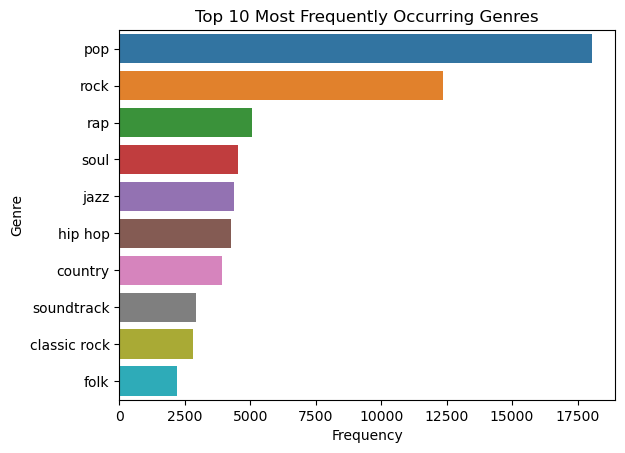

In [18]:
# Display the counts of the top 10 most frequently occurring genres in final_data 
top_10_genres_df = final_data['genre'].value_counts()[:10].rename_axis('Genre').reset_index(name = 'Frequency')

sns.barplot(x = top_10_genres_df.Frequency, y = top_10_genres_df.Genre, orient = 'h').set(title = 'Top 10 Most Frequently Occurring Genres')
plt.show()

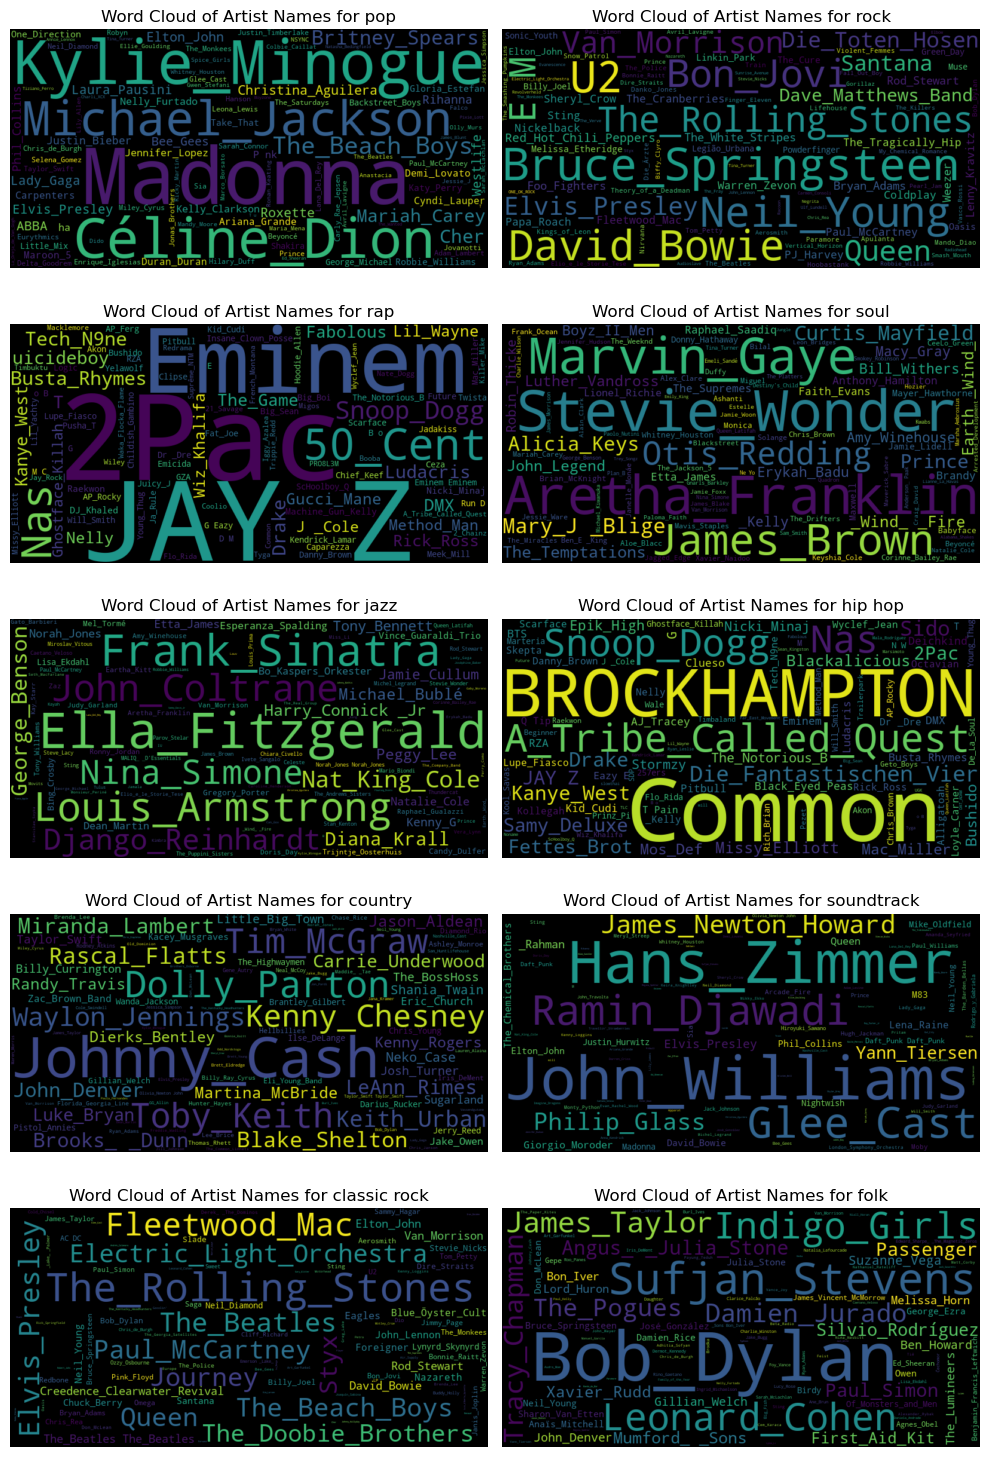

In [19]:
# Display the word clouds of artists for the top 10 most frequently occurring genres in final_data    
top_10_genres_list = final_data['genre'].value_counts()[:10].index.tolist()

# Initialize variables for subplot indexing
num_rows = 5
num_cols = 2
plot_index = 1

# Set a figure size
plt.figure(figsize = (10, 15))

# Generate a word cloud for each genre
for genre in top_10_genres_list:
    # Filter for the current genre
    genre_df = final_data[final_data['genre'] == genre]
    
    # Extract the artist names for the current genre
    artist_names = genre_df['track_artist'].tolist()
    
    # Replace spaces in the artist names with underscores
    underscored_artist_names = [artist.replace(' ', '_') for artist in artist_names]
    
    # Concatenate all underscored artist names into a single string
    all_artist_names = ' '.join(underscored_artist_names)
    
    # Generate a word cloud for the current genre
    wordcloud = WordCloud(width = 800, height = 400, max_words = 100, background_color = 'black').generate(all_artist_names)
    
    # Create a subplot for the current genre
    plt.subplot(num_rows, num_cols, plot_index)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(f'Word Cloud of Artist Names for {genre}')
    plt.axis('off')
    
    # Increment the plot index
    plot_index += 1

plt.tight_layout()
plt.show()

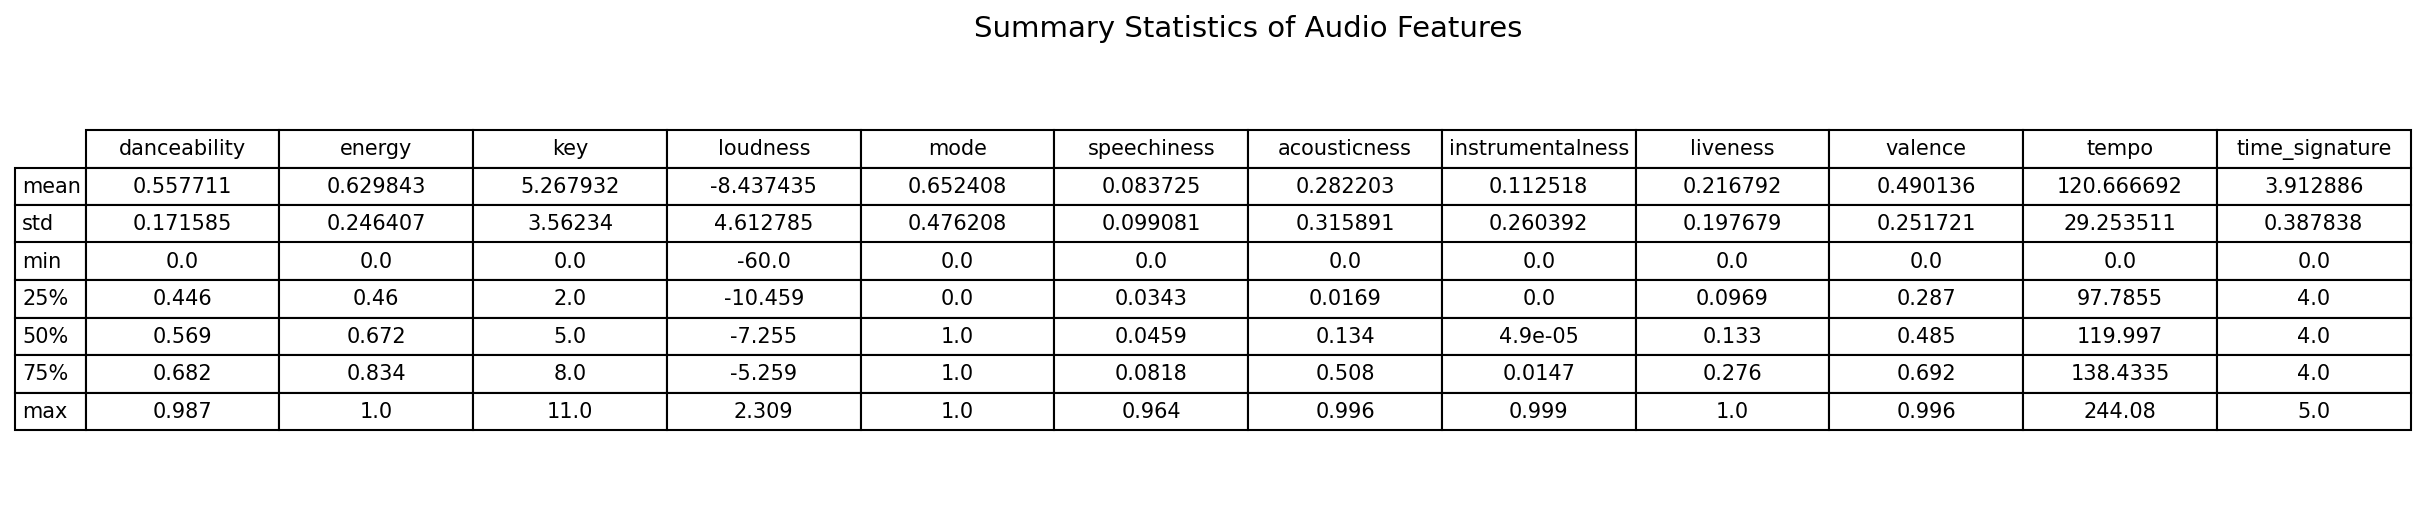

In [20]:
# Display the summary statistics of each audio feature in final_data  
audio_features_to_plot = final_data.iloc[:, list(range(3, 14)) + [15]]
summary_stats = pd.DataFrame(audio_features_to_plot.describe().round(6)).drop('count')

# Initialize a figure with an appropriate resolution
fig = plt.figure(figsize = (20, 4), dpi = 150)  

# Create a table
ax = fig.add_subplot(111)
table = ax.table(cellText = summary_stats.values, 
                 rowLabels = summary_stats.index, 
                 colLabels = summary_stats.columns, 
                 cellLoc = 'center', 
                 loc = 'center')

table.auto_set_font_size(False)
table.set_fontsize(10)  
table.scale(1, 1.5) 

ax.set_title('Summary Statistics of Audio Features', fontsize = 14)
ax.axis('off')
plt.show()

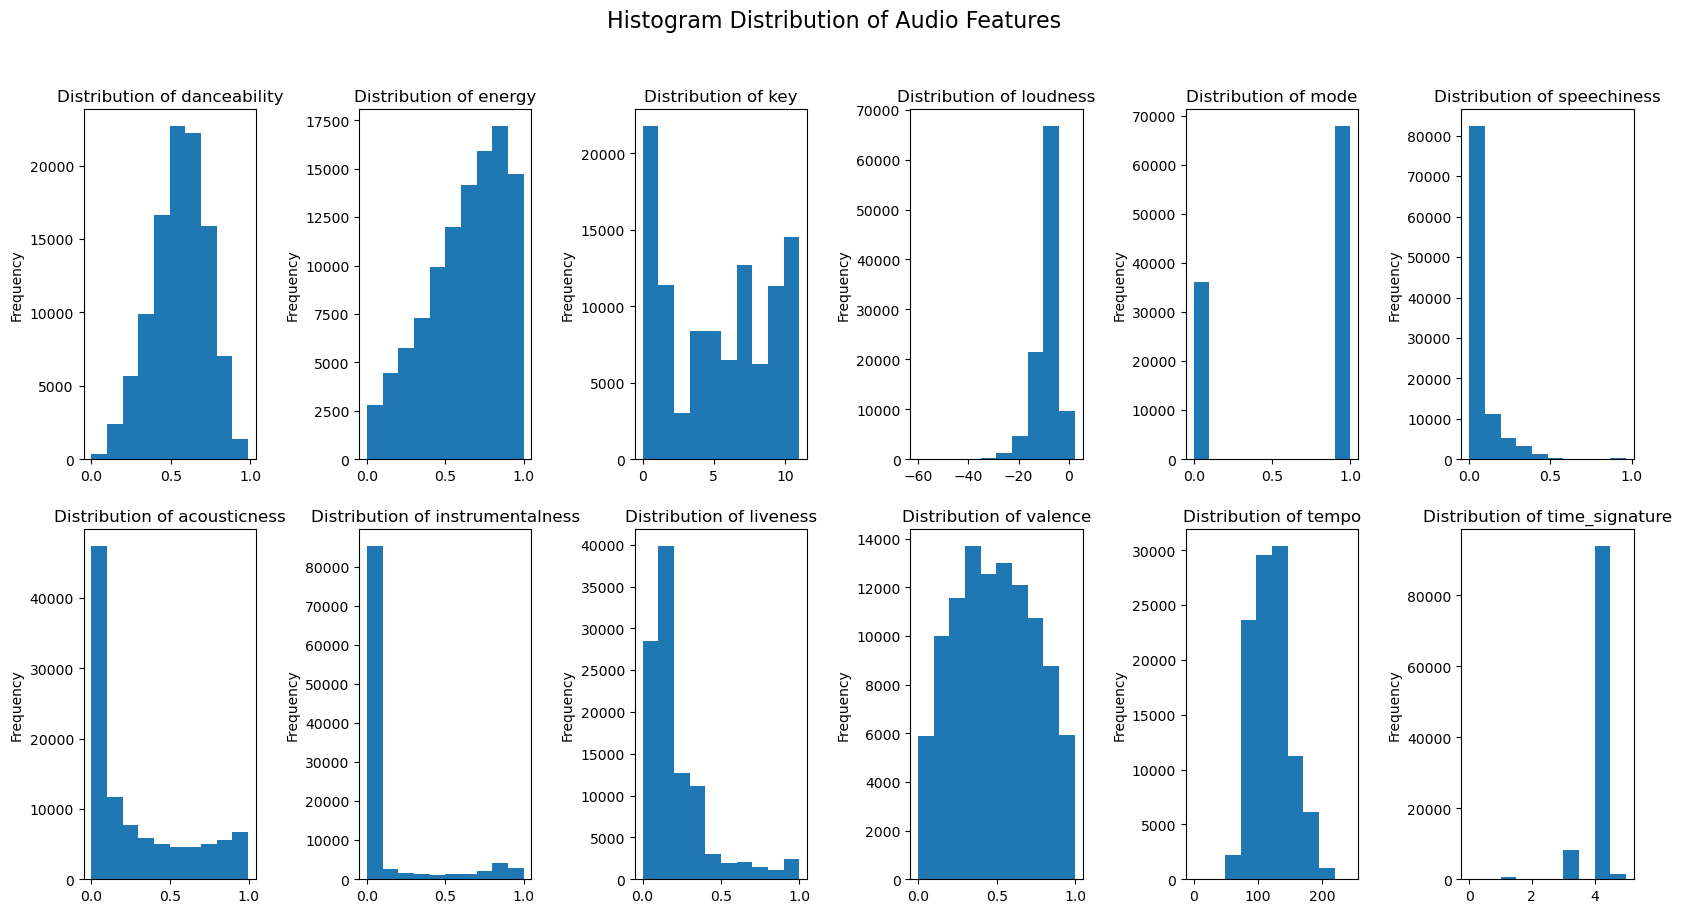

In [21]:
# Display the distribution of each audio feature in final_data on a histogram
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 10))

# Flatten the axes array to easily iterate over all subplots
axes = axes.flatten()

# Plot each audio feature in its respective subplot
for i, (col, ax) in enumerate(zip(audio_features_to_plot.columns, axes)):
    audio_features_to_plot[col].plot(kind = 'hist', ax = ax)
    ax.set_title('Distribution of ' + col)

plt.suptitle('Histogram Distribution of Audio Features', fontsize = 16)
plt.subplots_adjust(hspace = 0.2, wspace = 0.6)
plt.show()

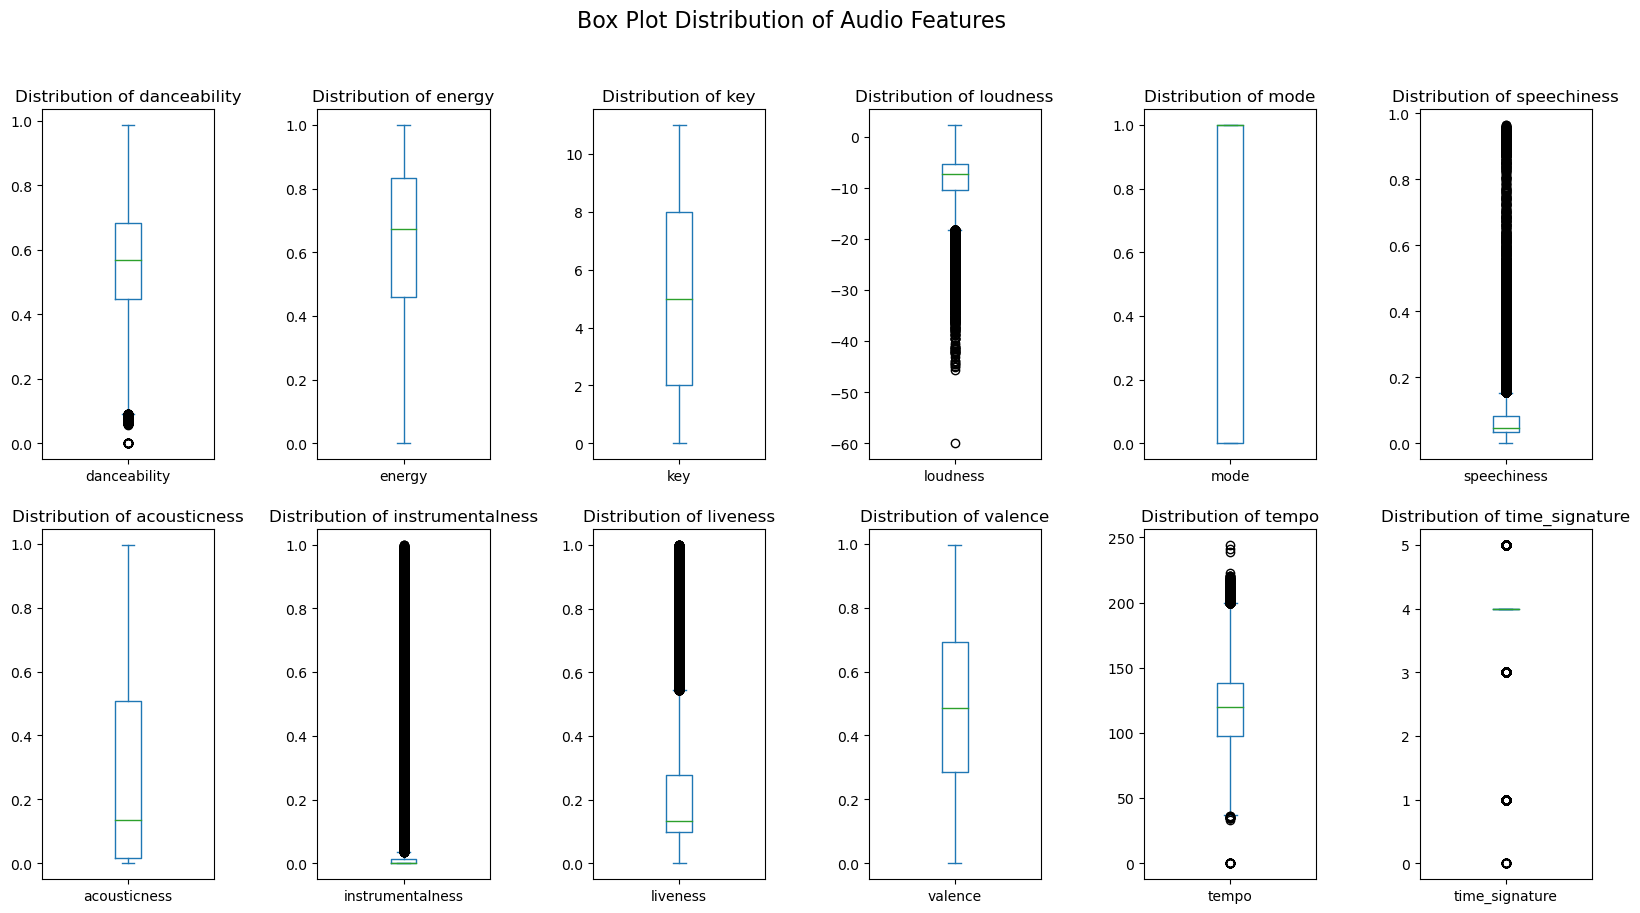

In [22]:
# Display the distribution of each audio feature in final_data on a box plot 
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 10))

# Flatten the axes array to easily iterate over all subplots
axes = axes.flatten()

# Plot each audio feature in its respective subplot
for i, (col, ax) in enumerate(zip(audio_features_to_plot.columns, axes)):
    audio_features_to_plot[col].plot(kind = 'box', ax = ax)
    ax.set_title('Distribution of ' + col)

plt.suptitle('Box Plot Distribution of Audio Features', fontsize = 16)
plt.subplots_adjust(hspace = 0.2, wspace = 0.6)
plt.show()

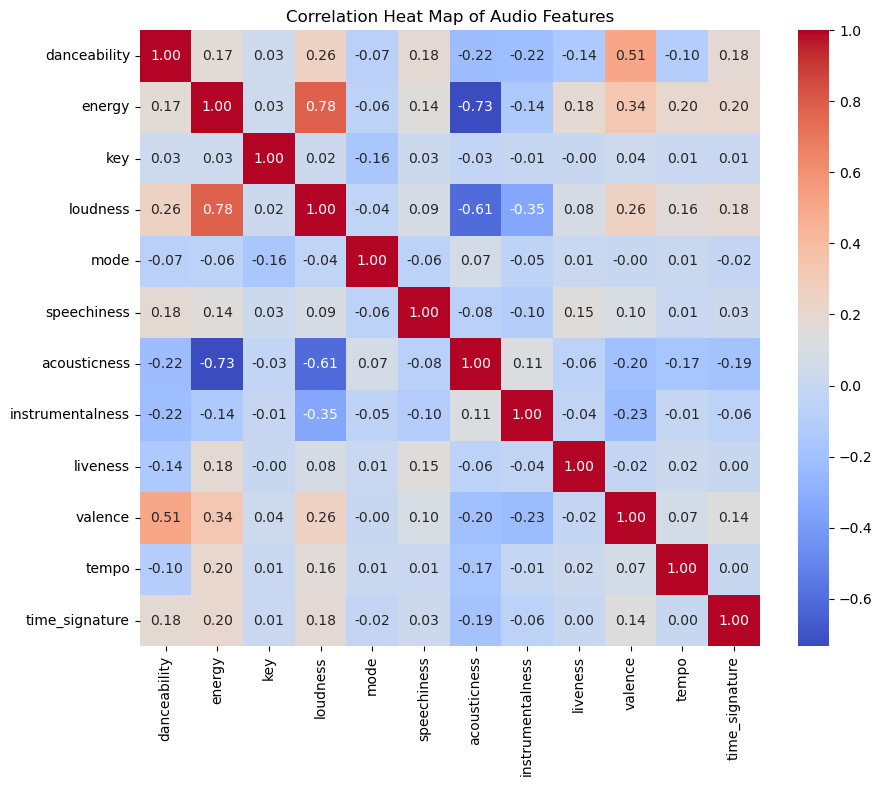

In [23]:
# Display the correlation between each pair of audio features in final_data on a heat map  
correlation_matrix = audio_features_to_plot.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Heat Map of Audio Features')
plt.show()

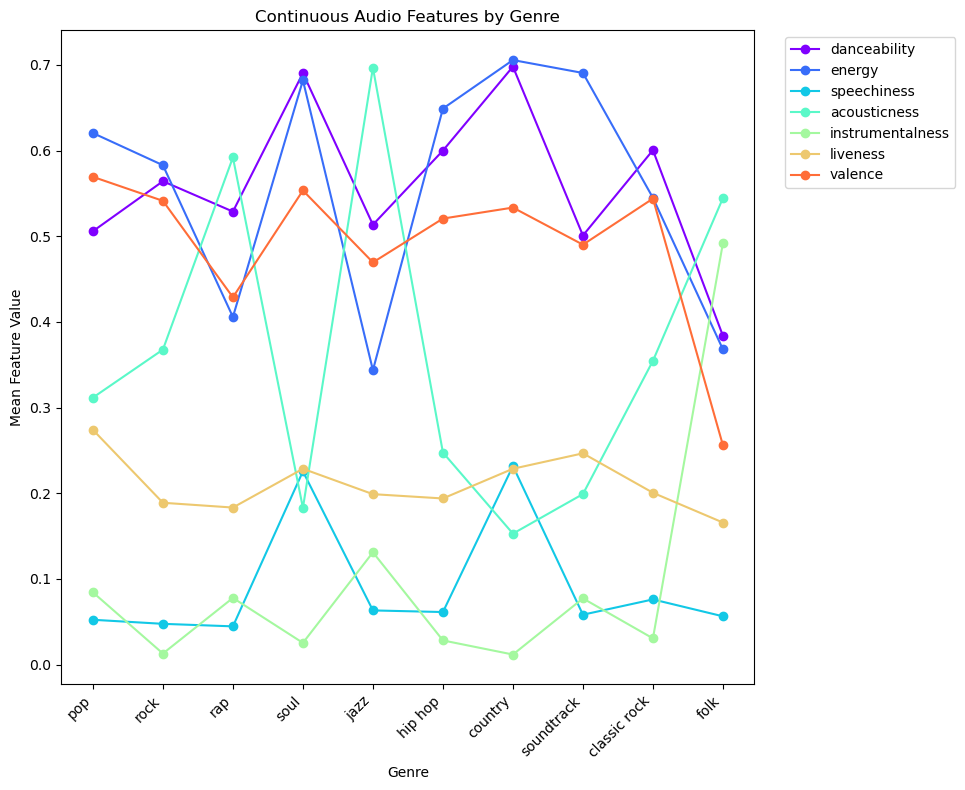

In [24]:
# Display the mean continuous audio feature values for the top 10 most frequently occurring genres in final_data on a line plot     
mean_feature_by_genre = final_data.groupby('genre')[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']].mean()
mean_feature_by_genre = mean_feature_by_genre[mean_feature_by_genre.index.isin(top_10_genres_list)]

num_features = 7

cmap = plt.get_cmap('rainbow')

# Set a figure size
plt.figure(figsize = (10, 8))

# Plot the curve for each continuous audio feature
index = 0
for feature in mean_feature_by_genre.columns.tolist():
    color = cmap(index / num_features)
    values = mean_feature_by_genre[feature]
    plt.plot(top_10_genres_list, values, label = feature, marker = 'o', color = color)
    index = index + 1

plt.title('Continuous Audio Features by Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Feature Value')
plt.xticks(rotation = 45, ha = 'right')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1))
plt.tight_layout()
plt.show()

# Non-Spotify User Playlists Data Import and Preprocessing

In [25]:
# Store Spotify playlists data in a DataFrame 
playlists_data = []
playlists = sp.user_playlists('spotify')

while playlists:
    for i, playlist in enumerate(playlists['items']):
        playlists_data.append({
            # Store each playlist's name
            'playlist_name': playlist['name'],
            # Store each playlist's URI
            'playlist_uri': playlist['uri'],
            # Store each playlist's external URL
            'playlist_external_url': playlist['external_urls']['spotify'],
            # Store each playlist's total number of tracks 
            'playlist_total_tracks': playlist['tracks']['total']
        })
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None
        
playlists_data = pd.DataFrame(playlists_data)

# Drop playlists with more than 100 tracks
playlists_data = playlists_data.drop(playlists_data[playlists_data['playlist_total_tracks'] > 100].index)

# Select 15 non-artist-specific playlists with consistent themes or genres across tracks
playlists_to_keep = ['RapCaviar', 'Hot Country','Nu Metal Era', 'Lo-Fi House', 'Grunge Forever',
                     'Summer Indie', 'Classic Punk', 'Timeless Soul Ballads', 'Disco Forever', 'Reggae Classics', 
                     'Top Picks Pop', 'Top Picks Jazz and Blues', 'Pure Rock & Roll', 'One-Hit Wonders', 'Top Shower Songs']

playlists_data = playlists_data[playlists_data['playlist_name'].isin(playlists_to_keep)].reset_index(drop = True)

playlists_data.head()

,playlist_name,playlist_uri,playlist_external_url,playlist_total_tracks
0,RapCaviar,spotify:playlist:37i9dQZF1DX0XUsuxWHRQd,https://open.spotify.com/playlist/37i9dQZF1DX0...,50
1,Hot Country,spotify:playlist:37i9dQZF1DX1lVhptIYRda,https://open.spotify.com/playlist/37i9dQZF1DX1...,50
2,Nu Metal Era,spotify:playlist:37i9dQZF1DXcfZ6moR6J0G,https://open.spotify.com/playlist/37i9dQZF1DXc...,80
3,Lo-Fi House,spotify:playlist:37i9dQZF1DXbXD9pMSZomS,https://open.spotify.com/playlist/37i9dQZF1DXb...,60
4,Grunge Forever,spotify:playlist:37i9dQZF1DX11ghcIxjcjE,https://open.spotify.com/playlist/37i9dQZF1DX1...,60


In [26]:
playlists_data.shape

(15, 4)

In [27]:
def get_playlist_tracks(playlist_id):
    ''' 
    Function that retrieves all the tracks in a Spotify playlist.
    
    Parameter playlist_id is a string indicating the ID or URI of a Spotify playlist. 
    
    Returns a list of dictionaries, where each dictionary represents a track in the Spotify playlist; each dictionary contains information about the track, such as its name, artist(s), duration, and other metadata.
    '''
    
    tracks = []
    results = sp.playlist_tracks(playlist_id)
    tracks.extend(results['items'])
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        
    return tracks

In [28]:
def get_audio_features(track_id):
    '''
    Function that retrieves the audio features of a Spotify track. 
    
    Parameter track_id is a string indicating the ID or URI of a Spotify track. 
    
    Returns a dictionary containing the audio features (danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, id, uri, track_href, analysis_url, duration_ms, and time_signature) of the Spotify track, or None if the Spotify track's audio features are not available.
    '''
    
    features = sp.audio_features(track_id)
    
    return features[0] if features else None

In [29]:
def prep_tracks_from_non_spotify_user_playlist(playlist_uri):
    '''
    Pre-processing function that extracts features from all tracks in a non-Spotify user playlist.
   
    Parameter playlist_uri is a string indicating a non-Spotify user's playlist's URI.
   
    Returns a DataFrame containing the playlist name and name, artist, audio features, and URI of each track in the non-Spotify user's playlist.    
    '''
    
    # Initialize empty lists to store data
    playlist_names = []
    track_names = []
    track_artists = []
    audio_features = []
    
    # Get all tracks in the playlist
    playlist_tracks = get_playlist_tracks(playlist_uri)
    
    # Get each track in the playlist
    for track in playlist_tracks:
        # Get each track's playlist name
        playlist_name = playlists_data[playlists_data['playlist_uri'] == playlist_uri]['playlist_name'].item()
        # Get each track's name
        track_name = track['track']['name']
        # Get each track's artist
        artist_names = [artist['name'] for artist in track['track']['artists']]
        artist = ', '.join(artist_names)
        # Get each track's audio features
        audio_feature = get_audio_features(track['track']['id'])
        
        if audio_feature:
            # If the track's audio features are available, append the track's data to each list 
            playlist_names.append(playlist_name)
            track_names.append(track_name)
            track_artists.append(artist)
            audio_features.append(audio_feature)
        
    # Create a DataFrame of the data collected
    df = pd.DataFrame({
        'playlist_name': playlist_names,
        'track_name': track_names,
        'track_artist': track_artists
    })

    # Store audio_features in a DataFrame, remove unnecessary columns, and rename columns 
    audio_features_df = pd.DataFrame(audio_features)
    audio_features_df = audio_features_df.drop(['type', 'id', 'track_href', 'analysis_url', 'duration_ms'], axis = 1)
    audio_features_df = audio_features_df.rename(columns = {'uri': 'track_uri'})
    
    # Concatenate each track's features into a DataFrame
    df = pd.concat([df, audio_features_df], axis = 1)
   
    return df

In [30]:
# Store the preprocessed input data in a input_data.csv file  
prep_tracks_from_non_spotify_user_playlist(playlists_data['playlist_uri'][0]).to_csv('input_data.csv', index = False, header = True)

for playlist_uri in playlists_data['playlist_uri'][1:].values:
    temp = prep_tracks_from_non_spotify_user_playlist(playlist_uri) 
    temp.to_csv('input_data.csv', mode = 'a', index = False, header = False)
    time.sleep(1) 

In [31]:
# Read in input_data.csv
input_data = pd.read_csv('input_data.csv')

input_data.head()

,playlist_name,track_name,track_artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_uri,time_signature
0,RapCaviar,CARNIVAL,"¥$, Kanye West, Ty Dolla $ign, Rich The Kid, P...",0.594,0.811,1,-5.746,1,0.1590,0.18900,0.000000,0.3390,0.3110,148.144,spotify:track:3w0w2T288dec0mgeZZqoNN,4
1,RapCaviar,redrum,21 Savage,0.624,0.740,2,-8.445,1,0.0481,0.00529,0.000224,0.5000,0.2460,172.089,spotify:track:52eIcoLUM25zbQupAZYoFh,4
2,RapCaviar,Whatever She Wants,Bryson Tiller,0.820,0.487,9,-7.358,0,0.0959,0.10200,0.000000,0.0803,0.4310,96.028,spotify:track:57wp7VFnV8X0pSVnYArGeJ,4
3,RapCaviar,Bandit,Don Toliver,0.671,0.615,1,-9.593,1,0.0955,0.00113,0.000001,0.2110,0.1090,130.031,spotify:track:7sTyAjxDXq9afwfSQy6D0s,4
4,RapCaviar,Never Lose Me,Flo Milli,0.781,0.567,1,-7.857,1,0.0969,0.05040,0.000000,0.0981,0.0743,121.964,spotify:track:6uTPdRrEDeH8Fyg5L5qmeU,4


In [32]:
input_data.shape

(1015, 16)

# Feature Selection

In [33]:
# Select the audio feature columns to be used in feature selection
features_df = final_data[['danceability', 'energy', 'key', 'loudness', 'mode',
                          'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
                          'tempo', 'time_signature']]

features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.864,0.495,0,-7.036,1,0.0370,0.591000,0.000133,0.0992,0.720,129.062,4
1,0.558,0.837,3,-4.405,1,0.0633,0.418000,0.000000,0.0821,0.488,117.963,4
2,0.762,0.484,11,-12.368,0,0.0311,0.812000,0.389000,0.0841,0.415,122.916,4
3,0.556,0.319,9,-8.251,1,0.0281,0.893000,0.000000,0.0996,0.294,135.187,4
4,0.502,0.912,1,-4.556,1,0.0564,0.000025,0.000173,0.1060,0.720,116.761,4


In [34]:
features_df.shape

(104243, 12)

In [35]:
# Convert genre to a numerical variable to be used in feature selection
target_col = final_data[['genre']]
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(np.ravel(target_col))
target_encoded = pd.DataFrame(target_encoded)

target_encoded.head()

,0
0,510
1,510
2,345
3,611
4,302


In [36]:
target_encoded.shape

(104243, 1)

In [37]:
# Calculate the mutual information between each variable in features_df and the genre variable
# Note: the mutual information between two variables is a non-negative value that measures the dependency between the variables; it is zero if and only if the variables are independent, and higher values mean higher dependency
mutual_info_scores = mutual_info_classif(features_df, np.ravel(target_encoded), random_state = 0)

# Display the scores from highest to lowest    
sorted_scores = sorted(zip(features_df.columns, mutual_info_scores), key = lambda x: x[1], reverse = True)
for feature, score in sorted_scores:
    print(f"{feature}: {score}")
    
# Note: we will select only the audio features with mutual information scores greater than 0.1 to be used in the recommender

acousticness: 0.2840487349032301
energy: 0.2434884197546454
speechiness: 0.20717883111690494
danceability: 0.2059827910251899
instrumentalness: 0.2017725196722564
loudness: 0.19947125661057186
tempo: 0.1874675078564536
valence: 0.11250005205408087
time_signature: 0.0683116412330751
key: 0.0435170260372848
liveness: 0.041165633717483274
mode: 0.04059366738544412


# Recommender System Building

In [38]:
def get_recommendations(final_data, input_data, playlist_name): 
    '''
    Function that provides five song track recommendations for a Spotify playlist.
    
    Parameter final_data is a DataFrame, of the final preprocessed data set, containing information on 104243 song tracks with each track's name, artist, genre, audio features, and URI.
    Parameter input_data is a DataFrame containing a series of tracks in Spotify playlists with each track's playlist name, name, artist, audio features, and URI. 
    Parameter playlist_name is a string indicating one of the Spotify playlist names contained in input_data.
    
    Returns a DataFrame containing the URI, name, artist, and genre of five song track recommendations for the Spotify playlist. 
    '''
    
    # Filter input_data to keep only tracks corresponding to the input playlist
    input_data = input_data[input_data['playlist_name'] == playlist_name].reset_index(drop = True)
    
    # Filter catalog_data to exclude tracks already in the input playlist
    catalog_data = final_data[~final_data['track_uri'].isin(input_data['track_uri'])]
    
    # Store the URI of each track in catalog_data for later
    catalog_data_track_uris_df = pd.DataFrame(catalog_data['track_uri'])
    
    # Restrict catalog_data and input_data to the columns from feature selection
    catalog_data = catalog_data[['danceability', 'energy', 'loudness', 'speechiness',
                                 'acousticness', 'instrumentalness', 'valence', 'tempo']]

    input_data = input_data[['danceability', 'energy', 'loudness', 'speechiness',
                             'acousticness', 'instrumentalness', 'valence', 'tempo']]

    # Standardize catalog_data and input_data
    scaler = StandardScaler()
    scaled_catalog_data = scaler.fit_transform(catalog_data)
    scaled_input_data = scaler.transform(input_data)

    # Normalize catalog_data and input_data
    normalized_catalog_data = normalize(scaled_catalog_data, axis = 1)
    normalized_input_data = normalize(scaled_input_data, axis = 1)
    
    # Use cosine similarity to measure the similarity between each track on the input playlist and each track in catalog_data
    # Note: similarity_scores range from -1 to 1, with -1 indicating strong dissimilarity and 1 indicating strong similarity
    similarity_scores = cosine_similarity(normalized_input_data, normalized_catalog_data)
    
    # Extract the indices of the top 5 most similar tracks to recommend  
    top_indices = similarity_scores.argsort(axis = 1)[:, -5:][:, ::-1]
    
    # Extract the recommended tracks based on their URIs 
    catalog_data = pd.concat([catalog_data, catalog_data_track_uris_df], axis = 1)
    recommended_track_ids = catalog_data.iloc[top_indices[0]]['track_uri']
    
    # Index the recommended tracks from final_data
    recommended_tracks = final_data[final_data['track_uri'].isin(recommended_track_ids)].reset_index(drop = True)
    
    # Return the recommended tracks's URIs, names, artists, and genres 
    recommended_tracks = recommended_tracks[['track_uri', 'track_name', 'track_artist', 'genre']]
    recommended_tracks.index += 1
    
    print('Here are five song track recommendations for your ' + playlist_name  + ' playlist:')
    return recommended_tracks

# Proof of Concept: Recommender System Evaluation With Non-Spotify User Playlists

In [39]:
# View the playlist names going to be used to evaluate the recommender system 
input_data.playlist_name.unique()

array(['RapCaviar', 'Hot Country', 'Nu Metal Era', 'Lo-Fi House',
       'Grunge Forever', 'Summer Indie', 'Classic Punk',
       'Timeless Soul Ballads', 'Disco Forever', 'Reggae Classics',
       'Top Picks Pop', 'Top Picks Jazz and Blues', 'Pure Rock & Roll',
       'One-Hit Wonders', 'Top Shower Songs'], dtype=object)

In [40]:
recommendations = get_recommendations(final_data, input_data, 'RapCaviar')
recommendations

Here are five song track recommendations for your RapCaviar playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:4xkOaSrkexMciUUogZKVTS,'Till I Collapse,Eminem,rap
2,spotify:track:3BEySnrRKBFlo8O5ekZ619,Leave Me Alone,Tech N9ne,rap
3,spotify:track:2prLJT67an2xDmyeKtCJiR,Money,DJ Khaled,rap
4,spotify:track:20F0Vgjn2v1TYcOASE0J7f,Always Picking On Me,S3RL,hardcore
5,spotify:track:7oSdf8HXNUtTbkupaW5kgU,Same Never Changed,S3RL,hardcore


In [41]:
recommendations = get_recommendations(final_data, input_data, 'Hot Country')
recommendations

Here are five song track recommendations for your Hot Country playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:3Z5No4LLIk2ryshwJMGbGU,La Mia Storia Tra Le Dita,Gianluca Grignani,pop
2,spotify:track:33RjM1DqRTcekJvEtISEzA,Kaunein unesi,Antti Tuisku,pop
3,spotify:track:2dEoWEN6gXbi9G9IZi5uh1,Ich glaub an dich,Yvonne Catterfeld,pop
4,spotify:track:3wMSO75aHi1FJnOhyAUgKZ,So Much In Love,Gyptian,reggae
5,spotify:track:4bI8EpSXcaZOeJYA7MDqZ7,Como Pudiste,Banda El Recodo,regional mexican


In [42]:
recommendations = get_recommendations(final_data, input_data, 'Nu Metal Era')
recommendations

Here are five song track recommendations for your Nu Metal Era playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:3g4GTF5OZrLrmk7hGZFkH8,If It's Love,Train,rock
2,spotify:track:0BS9fMzFfHTFNp9Sj97o58,Love Drunk,Little Mix,pop
3,spotify:track:5zUnTbfZ0hgXmhtLJcQ4D1,GOLD,UVERworld,alternative rock
4,spotify:track:36g45h1YP4ELl3XoUNmkaM,Que no te Haga Bobo Jacobo,Molotov,rock
5,spotify:track:6z9r12PJfgnCz9BWtqdNwb,Happy,Natasha Bedingfield,pop


In [43]:
recommendations = get_recommendations(final_data, input_data, 'Lo-Fi House')
recommendations

Here are five song track recommendations for your Lo-Fi House playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:1aWgejdEKIDmMOwDovMsOY,Pferd aus Glas,Deichkind,electro
2,spotify:track:7dTWkvPOPgbGuMk4HDxNpY,WDPK 83.7 FM,Daft Punk,house
3,spotify:track:1rWWKQYA1KIzTTZKSUFt8G,"Get In, Fit In",Ciara,soul
4,spotify:track:3rJHtp9aZnAnbYpTOCpP3l,Bomba,Deorro,trap
5,spotify:track:4VykLgflVeCyaxf8GlG6m9,Inna Di Car,Charly Black,dancehall


In [44]:
recommendations = get_recommendations(final_data, input_data, 'Grunge Forever')
recommendations

Here are five song track recommendations for your Grunge Forever playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:7Mgpf3WNIXiiSRRUbnTqnc,The Reincarnation of Benjamin Breeg,Iron Maiden,metal
2,spotify:track:3EWwXqQFCU1fslWA8kFe5q,The Nature of Reality,Oasis,rock
3,spotify:track:3CTrvulULlcIL2cJ5V7Qol,Like Father Like Son,The Word Alive,metalcore
4,spotify:track:50tgG4Ew9GkgZaIqucfwgt,Irgendwas bleibt,Silbermond,deutschrock
5,spotify:track:4GF5mA3XcdGRFr5fBVYBFD,What Love,Moby,rock


In [45]:
recommendations = get_recommendations(final_data, input_data, 'Summer Indie')
recommendations

Here are five song track recommendations for your Summer Indie playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:5gBEdUKVZJgvQwNu8pIQqy,for him.,Troye Sivan,pop
2,spotify:track:2D9itdl85AQVNpTfrxvUGj,Mala Fama,Danna Paola,reggaeton
3,spotify:track:5oN8yt71rUZCzNZul7Q2YO,Do U Wanna?,Mike Posner,hip hop
4,spotify:track:0lznEz2XNvwohH7uwJhZvy,Walk In My Shoes,Emily King,soul
5,spotify:track:6eoQOr5Bw1dfFEJYGmWIQn,All Around Me,Lil Yachty,trap


In [46]:
recommendations = get_recommendations(final_data, input_data, 'Classic Punk')
recommendations

Here are five song track recommendations for your Classic Punk playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:2U6RSyXFnDVNYoD9iUgi09,Bomb Bomb,KARD,k-pop
2,spotify:track:4HQ9li1KOoWnaQyt4AgzTX,Devil Made Me Do It,RuPaul,synthpop
3,spotify:track:3fi4doxNs7OYgE9aMWC2cZ,Pop (Radio Version),*NSYNC,pop
4,spotify:track:1UPcjyAe8SlVZ7r7EbtWJr,Hvis Du Forstod,Sanne Salomonsen,pop
5,spotify:track:3rTboU1EiIkKlA4CQh5i8W,Things Are Getting Better,N.E.R.D,hip hop


In [47]:
recommendations = get_recommendations(final_data, input_data, 'Timeless Soul Ballads')
recommendations

Here are five song track recommendations for your Timeless Soul Ballads playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:2eD5bmknmcojiCxoKpvVTI,Calypso,John Denver,country
2,spotify:track:3qeiYVCAgRav3EIGxy8O19,Apres l'amour,Charles Aznavour,chanson
3,spotify:track:6ezVa5KmCVNYVeIJ0at916,Enamorarse Asi,Pepe Aguilar,mariachi
4,spotify:track:30TDyKVKFfjwHGWAotz9VD,Angel,Pearl Jam,rock
5,spotify:track:4xZnXCGuoSmNiAJ6WVPw5n,And the Sun Will Shine,José Feliciano,singer-songwriter


In [48]:
recommendations = get_recommendations(final_data, input_data, 'Disco Forever')
recommendations

Here are five song track recommendations for your Disco Forever playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:0PWpenS4tZEHeOlS5Rt67L,System of Survival,"Earth, Wind & Fire",funk
2,spotify:track:4WjunARS8Uoq76DkBk67Pe,Scheisstyp,Die Ärzte,rock
3,spotify:track:0T6oYSJ8kLPN7a02xpDRZ3,I Don't Want to Be a Freak (But I Can't Help M...,Dynasty,disco
4,spotify:track:6dokyiv4HEy6WWxQCQcOkA,Happy People,The Temptations,funk
5,spotify:track:3xgT4zrbMDEufmP7YZD2zQ,Where's the Party (Dub version),Madonna,pop


In [49]:
recommendations = get_recommendations(final_data, input_data, 'Reggae Classics')
recommendations

Here are five song track recommendations for your Reggae Classics playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:4cEoFYEYKoILlUffLHmZEf,Wish You Were Here,Wyclef Jean,reggae
2,spotify:track:6bGuNHuwJH1G8HgGxZn7I6,Day One,Blackalicious,hip hop
3,spotify:track:38wnxXZdT2v7I31mHJ3Puv,Way Back,TLC,hip hop
4,spotify:track:2eYlaTqMz9WOXBTq7gzNkq,Money Makes The World Go Round,Scarface,rap
5,spotify:track:21Hb4Jm4pcmUddhBjHtRX7,Here With You,Brian McKnight,soul


In [50]:
recommendations = get_recommendations(final_data, input_data, 'Top Picks Pop')
recommendations

Here are five song track recommendations for your Top Picks Pop playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:1uPrIHgYztXSkkcts9jet8,She Bangs,Ricky Martin,latin
2,spotify:track:1Okn7K05zV0pr2FHQRAUau,Tanz mit mir,Bosse,pop
3,spotify:track:6tFW54zbAdRnid0jCGyDhM,Hot Damn Woman,Danko Jones,rock
4,spotify:track:0icTqKKKaSuOPUf4j0nVMv,After Midnight,Travie McCoy,hip hop
5,spotify:track:41vhG2EdqWXVeeuZTzO8aE,She Bangs (English Edit),Ricky Martin,pop


In [51]:
recommendations = get_recommendations(final_data, input_data, 'Top Picks Jazz and Blues')
recommendations

Here are five song track recommendations for your Top Picks Jazz and Blues playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:2nxzEMUmIhSJeGBaXgh30x,Calling All Angels,Lenny Kravitz,rock
2,spotify:track:2RtvkLz5tmOXlzz918It6E,Fortunate,Maxwell,soul
3,spotify:track:6XLAg0OJBMDhmiPW1lnNmz,Tabt Mit Hjerte,Anne Linnet,pop
4,spotify:track:2NMrfvOqgJDatLJq7c9qKQ,Sweet Garden,Miss Platnum,hip hop
5,spotify:track:4EW2qSfWaEwEqjg0BO988o,Once Upon A Time,Montell Jordan,pop


In [52]:
recommendations = get_recommendations(final_data, input_data, 'Pure Rock & Roll')
recommendations

Here are five song track recommendations for your Pure Rock & Roll playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:2SiXAy7TuUkycRVbbWDEpo,You Shook Me All Night Long,AC/DC,hard rock
2,spotify:track:0164s4rGkAgFgQJcJ4q2Z5,For The Sun,Amanda Jenssen,pop
3,spotify:track:02Y5iPKfoq1EzJuHptJ1xE,Numb As A Statue,Warren Zevon,rock
4,spotify:track:4J5552ivjxSeehflU0wmI8,Revenge,Eurythmics,britpop
5,spotify:track:1TEENUuwRk0KVdbXhTaa0x,Riemulla,Maija Vilkkumaa,pop


In [53]:
recommendations = get_recommendations(final_data, input_data, 'One-Hit Wonders')
recommendations

Here are five song track recommendations for your One-Hit Wonders playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:67OTvR4W0NFEWLrQRL2QGw,Sick Cycle Carousel,Lifehouse,rock
2,spotify:track:12OSMguMAd7bDYFhy7bQek,What You Want,Toro y Moi,indie rock
3,spotify:track:5BkNCuxzzid0gz9sx3NNbX,My Silver Lining,First Aid Kit,folk
4,spotify:track:2NVDqyBmkPLANgy3S5He6d,There Goes My Miracle,Bruce Springsteen,rock
5,spotify:track:62qJJckOcu92deFFHknyMK,Oración,Heroes Del Silencio,rock


In [54]:
recommendations = get_recommendations(final_data, input_data, 'Top Shower Songs')
recommendations

Here are five song track recommendations for your Top Shower Songs playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:1nAGuIZXz6vb8XW0xiMqic,Papi,Jennifer Lopez,pop
2,spotify:track:3y9l6k1sTwXgJ3L80IfrS9,Defeat You,Smash Mouth,rock
3,spotify:track:3ZxqRrKOSjBEZVZkBGjpWh,Mares de emocion,Elvis Crespo,merengue
4,spotify:track:4OzQg5IcAkBxQV6Awq2T0y,That Don't Impress Me Much (Dance Mix),Shania Twain,pop
5,spotify:track:2yZhYOrX9ukmcyfIjGYx9O,Bodrum,Hande Yener,pop


# Current Spotify User Playlists Data Import and Preprocessing

In [55]:
def prep_tracks_from_current_spotify_user_playlists(): 
    '''
    Pre-processing function that extracts features from all tracks in a current Spotify user's playlists.
    
    Note: you must be logged into the current Spotify user's account you want this function to extract data from. 
    
    Returns a DataFrame containing the playlist name and name, artist, audio features, and URI of each track in the current Spotify user's playlists.    
    '''
    
    # Initialize empty lists to store data
    playlist_names = []
    track_names = []
    track_artists = []
    audio_features = []
    
    # Get the current user's playlists
    user_playlists = sp.current_user_playlists()
    
    for playlist in user_playlists['items']:
        # Get the playlist name
        playlist_name = playlist['name']
        
        # Get all tracks in the playlist
        playlist_id = playlist['id']
        playlist_tracks = get_playlist_tracks(playlist_id)
        
        # Get each track in the playlist
        for track in playlist_tracks:
            # Get each track's name
            track_name = track['track']['name']
            # Get each track's artist
            artist_names = [artist['name'] for artist in track['track']['artists']]
            artist = ', '.join(artist_names)
            # Get each track's audio features
            audio_feature = get_audio_features(track['track']['id'])
            
            if audio_feature:
                # If the track's audio features are available, append the track's data to each list 
                playlist_names.append(playlist_name)
                track_names.append(track_name)
                track_artists.append(artist)
                audio_features.append(audio_feature)
    
    # Create a DataFrame of the data collected
    df = pd.DataFrame({'playlist_name': playlist_names,
                       'track_name': track_names,
                       'track_artist': track_artists})

    # Store audio_features in a DataFrame, remove unnecessary columns, and rename columns 
    audio_features_df = pd.DataFrame(audio_features)
    audio_features_df = audio_features_df.drop(['type', 'id', 'track_href', 'analysis_url', 'duration_ms'], axis = 1)
    audio_features_df = audio_features_df.rename(columns = {'uri': 'track_uri'})
    
    # Concatenate each track's features into a DataFrame
    df = pd.concat([df, audio_features_df], axis = 1)
      
    return df

# Live Demo: Recommender System Evaluation With Current Spotify User Playlists

In [56]:
# Note for the code-runner: 
# 1) Add the Spotify user you want to allow access to your web app (in development mode) before running the following code cell
#    - To do this, go to Dashboard > your web app > Settings > User Management > enter the user's Full Name and Email > Add user
# 2) Log into the Spotify user's account you want to access before running the following code cell

In [57]:
# Connect to the Spotify Web API to access a current Spotify user's account 
REDIRECT_URI = 'http://localhost:8888'

sp_oauth = SpotifyOAuth(client_id = CLIENT_ID,
                        client_secret = CLIENT_SECRET,
                        redirect_uri = REDIRECT_URI,
                        scope = 'user-read-private user-read-email', 
                        open_browser = False)

# Redirect the code-runner to the authorization URL
auth_url = sp_oauth.get_authorize_url()
print(f"Please visit this URL to authorize your Spotify account: {auth_url}")

# After the code-runner grants access, Spotify will redirect them back to REDIRECT_URI with an authorization code

# Parse the REDIRECT_URI and extract the authorization code
authorization_code = input("Enter the authorization code from the URL: ")

# Exchange the authorization code for access and refresh tokens
token_info = sp_oauth.get_access_token(authorization_code)

# Access the current Spotify user's account 
access_token = token_info['access_token']
sp = spotipy.Spotify(auth = access_token)

# Now the code-runner can make requests to the current Spotify user's account through the Spotify Web API using 'sp'

Please visit this URL to authorize your Spotify account: https://accounts.spotify.com/authorize?client_id=c7dc056ee04f49ae831dd80f212daaf0&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888&scope=user-read-private+user-read-email
Enter the authorization code from the URL: AQAj4YbM6n7ZB7kGSHtWZIguhGgzrixSqYY0MfnS1gFz6O9Aui-n4fIl82xqeu8MjqDxPNaJdOHQI18nmNdlu3nz2uI6qVbPS7IstPeIH3KEuG0AQClTx8HAXGFksMP3FA_FuRl3lXszNNGIZFw8--f8CMiyWKXVRO5xE_Pi7WuXyFYst0tvoUAPsWjFguKz8U6aO7Ie9aA1qx-fow


/var/folders/md/ngp0zl151bvc45cgs3rfj6rc0000gn/T/ipykernel_6254/4014491849.py:20: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token(authorization_code)


In [58]:
# Print the current Spotify user's playlist names that were extracted
user_data = prep_tracks_from_current_spotify_user_playlists()
print('These are your playlist options: ', user_data.playlist_name.unique())

# Prompt the code-runner to pick one of the playlist names that were extracted to recieve recommendations for
input_playlist = input('Pick a playlist to get recommendations for: ')

# Ouptut the recommendations
recommendations = get_recommendations(final_data, user_data, input_playlist)
recommendations

These are your playlist options:  ['My Fairytale' 'Favorites1']
Pick a playlist to get recommendations for: My Fairytale
Here are five song track recommendations for your My Fairytale playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:2s5HHHAI3Mys2W63YTpB9c,You & A Promise,Howie Day,rock
2,spotify:track:3uKgWmEuxtsKt3elrXRVa8,Arms of Salvation,The Common Linnets,country
3,spotify:track:46b149mMnK4WXgQuGia4a9,Rudens,Prāta Vētra,britpop
4,spotify:track:6lNXCSjZkD8AAEskJdPIBr,The Lowdown,B.B. King,blues
5,spotify:track:08unnSlf8FAeMPFQ8O3F0U,Love Don't Bother Me,Sanne Salomonsen,rock


In [59]:
recommendations = get_recommendations(final_data, user_data, 'Favorites1')
recommendations

Here are five song track recommendations for your Favorites1 playlist:


,track_uri,track_name,track_artist,genre
1,spotify:track:5DiRcqIW1nLBzcDYKkFKId,Codes,Ellie Goulding,electropop
2,spotify:track:0XQHz5C8PknyrEhyrKxVKa,Down,Fifth Harmony,pop
3,spotify:track:5nvp7lpex9eNqFZSWiXVxc,One More,Elliphant,pop
4,spotify:track:3ZkUWF1MVm3tLgz7dplGpk,The Way I Are (Dance with Somebody) [feat. Lil...,Bebe Rexha,pop
5,spotify:track:04c9W375VlrbMF7P03CyWA,Ma vie,Dadju,soul
